In [1]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline


from imblearn.pipeline import Pipeline 
import time

# 1. Classification of Facial Expressions


### 1.1 Importing the data

In [52]:
#load the data
data = np.load("2023683_face.npz")
data.files
data["X_train"]

array([[100,  96,  92, ...,   2,  14,   8],
       [ 56,  93,  96, ...,  10,  13,  10],
       [ 91,  95, 100, ..., 125,  26,   3],
       ...,
       [145, 161, 172, ..., 127,  42,  87],
       [148, 166, 177, ..., 185, 185,  74],
       [136, 155, 165, ..., 123, 145, 143]], dtype=int64)

In [53]:
#put the data into corresponding arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
X_valid = data["X_valid"]
y_valid = data["y_valid"]

### 1.2 EDA

In [54]:
print(X_train.shape)
print(y_train.shape)

(1930, 2304)
(1930,)


In [55]:
#unique categories 
np.unique(y_train)

array([0, 1, 2], dtype=int64)

In [56]:
X_train

array([[100,  96,  92, ...,   2,  14,   8],
       [ 56,  93,  96, ...,  10,  13,  10],
       [ 91,  95, 100, ..., 125,  26,   3],
       ...,
       [145, 161, 172, ..., 127,  42,  87],
       [148, 166, 177, ..., 185, 185,  74],
       [136, 155, 165, ..., 123, 145, 143]], dtype=int64)

In [57]:
X_train[0].shape

(2304,)

#### 1.2.1 Plotting an image from each category in the data 

In [58]:
#finding the indexes of the first occurances of the unique categories 
unique_categories = np.unique(y_train, return_index=True)[1]

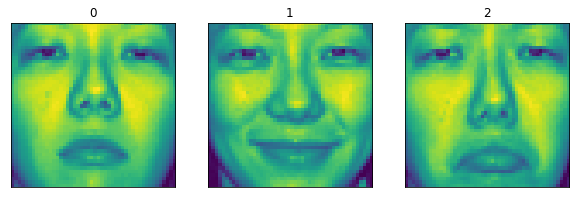

In [59]:
#idea adopted from practical 10 
fig, axs = plt.subplots(1, 3, figsize=(10, 10), subplot_kw={'xticks': (), 'yticks': ()})

for index, ax in zip(unique_categories, [0,1,2]):
    image = X_train[index]
    # an instance has 2304 features meaning that the square root of this number 
    # gives the the dimensions of the image
    image.resize(48, 48)
    axs[ax].imshow(image)
    axs[ax].set_title(y_train[index])

#### 1.2.2 Displaying the number of observations for each class

In [60]:
#combining all the target labels 
combined_labels = np.concatenate((y_train, y_test, y_valid))

In [61]:
combined_labels.shape

(2401,)

Text(0, 0.5, 'Count')

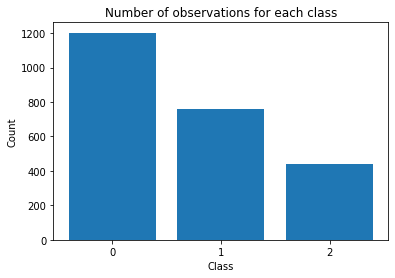

In [62]:
labels, counts = np.unique(combined_labels, return_counts=True)
plt.bar(labels, counts)
plt.xticks(labels)
plt.title("Number of observations for each class")
plt.xlabel("Class")
plt.ylabel("Count")

In [63]:
#balancing the data using RandomOverSampler
ros = RandomOverSampler(random_state=202, sampling_strategy='not majority')
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
X_test_res, y_test_res = ros.fit_resample(X_test, y_test)
X_valid_res, y_valid_res = ros.fit_resample(X_valid, y_valid)

The data seems to be unbalanced because category 0 is observed 1200 times, 1 - a little less than 800 and 2 - around 400.

Fitting a PCA:

In [64]:
#starting with a PCA with 250 components
pca = PCA(n_components=250, random_state=202)
pca.fit(X_train_res)
X_train_pca = pca.transform(X_train_res)
X_test_pca = pca.transform(X_test_res)
X_train_pca.shape

(2889, 250)

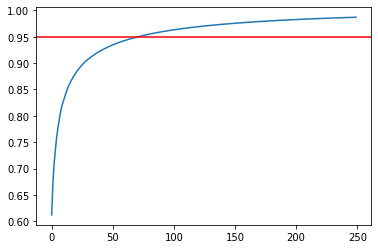

In [65]:
#plotting the explained variance ratio: looks like the best number of components is around 75
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')

In [66]:
#initializing a PCA with 75 components
pca = PCA(n_components=75, random_state=202)
pca.fit(X_train_res)
X_train_pca = pca.transform(X_train_res)
X_test_pca = pca.transform(X_test_res)
X_valid_pca = pca.transform(X_valid_res)

### 1.3 Classfication task 

#### 1.3.1 Training KNN Classifier 

Initializing the baseline model. 

In [67]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train_res)
pred = knn.predict(X_test_pca)

print(f"Test set score: {knn.score(X_test_pca, y_test_res)}")
end = time.time()

print(f"Time elapsed: {end-start}")
print(f"Confusion matrix:\n {metrics.confusion_matrix(y_test_res, pred)}")
target_names = ['class 0', 'class 1', 'class 2']
print(f"Classification report:\n {metrics.classification_report(y_test_res, pred, target_names=target_names)}")

Test set score: 0.6502732240437158
Time elapsed: 0.07080960273742676
Confusion matrix:
 [[108   3  11]
 [ 25  95   2]
 [ 72  15  35]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.53      0.89      0.66       122
     class 1       0.84      0.78      0.81       122
     class 2       0.73      0.29      0.41       122

    accuracy                           0.65       366
   macro avg       0.70      0.65      0.63       366
weighted avg       0.70      0.65      0.63       366



Plotting missclassified images.

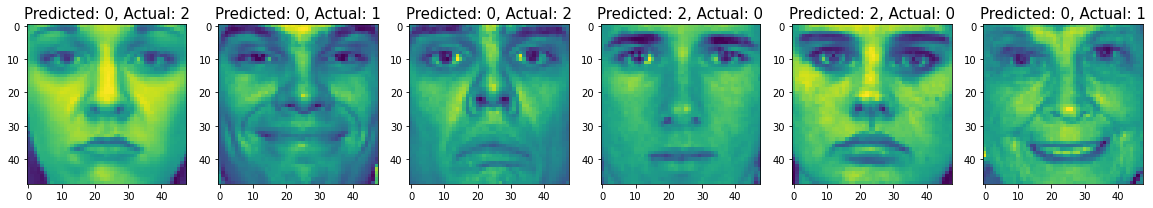

In [68]:
#displaying two missclassified images for each class (code adapted from workbook 11)
index = 0
misclassifiedIndexes = []

lab_0 = 0
lab_1 = 0
lab_2 = 0

for label, predict in zip(y_test_res, pred):
    if label != predict:
        #we need this part in order to have only 2 images from each class
        if label == 0 and lab_0 < 2:
            misclassifiedIndexes.append(index)
            lab_0 += 1
        elif label == 1 and lab_1 < 2:
            misclassifiedIndexes.append(index)
            lab_1 += 1
        elif label == 2 and lab_2 < 2:
            misclassifiedIndexes.append(index)
            lab_2 += 1
    index +=1

# plot the corresponding image of the 6th to 9th element in the array 
plt.figure(figsize=(20, 20))
for plotIndex, badIndex in enumerate(misclassifiedIndexes):
    plt.subplot(1, 6, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (48,48)))    
    plt.title(f'Predicted: {pred[badIndex]}, Actual: {y_test_res[badIndex]}', fontsize = 15)

#### 1.3.2 Finding the optimal number of neighbors for KNN

In [69]:
#finding the best number of neighbors using a loop 
n_neighbors = [1, 2, 3, 4, 5, 6]
max_accuracy = 0
best_neighbors = 0

start = time.time()
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train_pca, y_train_res)
    
    if knn.score(X_valid_pca, y_valid_res) > max_accuracy:
        max_accuracy = knn.score(X_valid_pca, y_valid_res)
        best_neighbors = n

print(f"Best accuracy: {max_accuracy:.2f}")
print(f"Optimal number of neighbors: {best_neighbors}")
end = time.time()
print(f"Time elapsed: {end-start}")

#evaluate model on test set

knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X_train_pca, y_train_res)
test_score = knn.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, knn.predict(X_test_pca), target_names=target_names)}")

Best accuracy: 0.66
Optimal number of neighbors: 5
Time elapsed: 0.2662501335144043
Test set score with best parameters: 0.6912568306010929
Classification report:
               precision    recall  f1-score   support

     class 0       0.59      0.82      0.69       122
     class 1       0.88      0.70      0.78       122
     class 2       0.68      0.55      0.61       122

    accuracy                           0.69       366
   macro avg       0.72      0.69      0.69       366
weighted avg       0.72      0.69      0.69       366



#### 1.3.3 Fitting different classifiers  

For the hyperparameter tunings I used this resource. It had some useful tips for the different models. 
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [20]:
#SVM Classifier without hyperparameter tuning
start = time.time()
svc = SVC()
svc.fit(X_train_pca, y_train_res)
pred = svc.predict(X_test_pca)
end = time.time()

print(f"Time elapsed: {end-start}")
print(f"Test set score: {svc.score(X_test_pca, y_test_res)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, pred, target_names=target_names)}")

Time elapsed: 0.4777240753173828
Test set score: 0.8360655737704918
Confusion matrix:
[[ 95   5  22]
 [  3 113   2]
 [ 24   4  98]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.78      0.78      0.78       122
     class 1       0.96      0.93      0.94       122
     class 2       0.78      0.80      0.79       122

    accuracy                           0.84       366
   macro avg       0.84      0.84      0.84       366
weighted avg       0.84      0.84      0.84       366



In [21]:
#SVM Classifier with hyperparameter tuning
best_score = 0
best_parameters = {}

start = time.time()
for C in [0.01, 0.1, 1, 10, 100]:
    for kernel in ["rbf", 'poly']:
        #fitting a model for each combination of hyperparemeters
        svc =  SVC(C=C, kernel=kernel)
        svc.fit(X_train_pca, y_train_res)
        
        #evaluating the model on the validation set
        score = svc.score(X_valid_pca, y_valid_res)
        
        if score > best_score:
            best_score = score 
            best_parameters = {'C': C, 'kernel':kernel}


print(f"Best score: {best_score:.2f}")
print(f"Best hyperparameters: {best_parameters}")
end = time.time()
print(f"Time elapsed: {end-start}")
# fitting the model with best parameters on the test set

svc =  SVC(**best_parameters)
svc.fit(X_train_pca, y_train_res)
test_score = svc.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, svc.predict(X_test_pca), target_names=target_names)}")

Best score: 0.90
Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Time elapsed: 5.4803009033203125
Test set score with best parameters: 0.8333333333333334
Classification report:
               precision    recall  f1-score   support

     class 0       0.72      0.88      0.79       122
     class 1       0.97      0.91      0.94       122
     class 2       0.85      0.71      0.78       122

    accuracy                           0.83       366
   macro avg       0.85      0.83      0.83       366
weighted avg       0.85      0.83      0.83       366



In [22]:
#Decision Tree Classifier without hyperparameter tuning
start = time.time()
dtc = DecisionTreeClassifier(random_state = 202)

dtc.fit(X_train_pca, y_train_res)
end = time.time()
print(f"Time elapsed: {end-start}")

pred = dtc.predict(X_test_pca)
print(f"Test set score: {dtc.score(X_test_pca, y_test_res)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, pred, target_names=target_names)}")

Time elapsed: 0.17658352851867676
Test set score: 0.6229508196721312
Confusion matrix:
[[91 20 64]
 [ 8 93 14]
 [23  9 44]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.52      0.75      0.61       122
     class 1       0.81      0.76      0.78       122
     class 2       0.58      0.36      0.44       122

    accuracy                           0.62       366
   macro avg       0.64      0.62      0.61       366
weighted avg       0.64      0.62      0.61       366



In [23]:
#Decision Tree Classifier with hyperparameter tuning

best_score = 0
best_parameters = {}

start = time.time()
for criterion in ['gini', 'entropy']:
    for max_depth in [3,6,9,12,15,17,20]:
        for splitter in ['best', 'random']:
            #fitting a model for each combination of hyperparemeters
            dtc = DecisionTreeClassifier(random_state=202, criterion=criterion, max_depth=max_depth, splitter=splitter)
            dtc.fit(X_train_pca, y_train_res)
        
            #evaluating the model on the validation set
            score = dtc.score(X_valid_pca, y_valid_res)
        
            if score > best_score:
                best_score = score 
                best_parameters = {'criterion': criterion, 'max_depth':max_depth, 'splitter':splitter}


print(f"Best score: {best_score:.2f}")
print(f"Best hyperparameters: {best_parameters}")
end = time.time()
print(f"Time elapsed: {end-start}")

# fitting the model with best parameters on the test set

dtc = DecisionTreeClassifier(**best_parameters, random_state=202)
dtc.fit(X_train_pca, y_train_res)
test_score = dtc.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(dtc.predict(X_test_pca), y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, dtc.predict(X_test_pca), target_names=target_names)}")

Best score: 0.74
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 9, 'splitter': 'best'}
Time elapsed: 2.6220104694366455
Test set score with best parameters: 0.7049180327868853
Confusion matrix:
[[78 14 32]
 [11 99  9]
 [33  9 81]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.63      0.64      0.63       122
     class 1       0.83      0.81      0.82       122
     class 2       0.66      0.66      0.66       122

    accuracy                           0.70       366
   macro avg       0.71      0.70      0.71       366
weighted avg       0.71      0.70      0.71       366



In [24]:
#Logistic Regression without hyperparameter tuning
start = time.time()
log_reg = LogisticRegression(max_iter = 10000)
log_reg.fit(X_train_pca, y_train_res)
end = time.time()
print(f"Time elapsed: {end-start}")
pred = log_reg.predict(X_test_pca)
print(f"Test set score: {log_reg.score(X_test_pca, y_test_res)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, pred, target_names=target_names)}")

Time elapsed: 3.8905959129333496
Test set score: 0.8278688524590164
Confusion matrix:
[[ 99   4  27]
 [  4 109   0]
 [ 19   9  95]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.76      0.81      0.79       122
     class 1       0.96      0.89      0.93       122
     class 2       0.77      0.78      0.78       122

    accuracy                           0.83       366
   macro avg       0.83      0.83      0.83       366
weighted avg       0.83      0.83      0.83       366



In [25]:
#Logistic Regression with hyperparameter tuning

best_score = 0
best_parameters = {}

start = time.time()
for C in [0.0001, 0.01, 0.1, 1, 10]:
    for solver in ['newton-cg', 'lbfgs', 'sag']:
            #fitting a model for each combination of hyperparemeters
            log_reg = LogisticRegression(solver=solver, C=C,max_iter = 10000)
            log_reg.fit(X_train_pca, y_train_res)
        
            #evaluating the model on the validation set
            score = log_reg.score(X_valid_pca, y_valid_res)
        
            if score > best_score:
                best_score = score 
                best_parameters = {'solver':solver, 'C':C}


print(f"Best score: {best_score:.2f}")
print(f"Best hyperparameters: {best_parameters}")
end = time.time()
print(f"Time elapsed: {end-start}")

# fitting the model with best parameters on the test set

log_reg = LogisticRegression(**best_parameters, max_iter = 10000)
log_reg.fit(X_train_pca, y_train_res)
test_score = log_reg.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(log_reg.predict(X_test_pca), y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, log_reg.predict(X_test_pca), target_names=target_names)}")

Best score: 0.82
Best hyperparameters: {'solver': 'newton-cg', 'C': 0.0001}
Time elapsed: 31.4239661693573
Test set score with best parameters: 0.8306010928961749
Confusion matrix:
[[ 98   5  27]
 [  4 111   0]
 [ 20   6  95]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.75      0.80      0.78       122
     class 1       0.97      0.91      0.94       122
     class 2       0.79      0.78      0.78       122

    accuracy                           0.83       366
   macro avg       0.83      0.83      0.83       366
weighted avg       0.83      0.83      0.83       366



In [49]:
#MLP classifier without hyperparameter tuning
start = time.time()
mnb = MLPClassifier(random_state=202, max_iter=1000)
mnb.fit(X_train_pca, y_train_res)
end = time.time()
print(f"Time elapsed: {end-start}")
pred = mnb.predict(X_test_pca)
print(f"Test set score: {mnb.score(X_test_pca, y_test_res)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, pred, target_names=target_names)}")

Time elapsed: 0.8547160625457764
Test set score: 0.8087431693989071
Confusion matrix:
[[106  16  36]
 [  8 106   2]
 [  8   0  84]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.67      0.87      0.76       122
     class 1       0.91      0.87      0.89       122
     class 2       0.91      0.69      0.79       122

    accuracy                           0.81       366
   macro avg       0.83      0.81      0.81       366
weighted avg       0.83      0.81      0.81       366



In [27]:
#MLP Classifier with hyperparameter tuning

best_score = 0
best_parameters = {}

start = time.time()
for alpha in [0.001, 0.01, 0.1, 0.5, 0.7 ,0.8]:
    #fitting a model for each combination of hyperparemeters
    mnb = MLPClassifier(alpha=alpha, max_iter = 1000, random_state=202)
    mnb.fit(X_train_pca, y_train_res)
        
    #evaluating the model on the validation set
    score = mnb.score(X_valid_pca, y_valid_res)
        
    if score > best_score:
        best_score = score 
        best_parameters = {'alpha': alpha}


print(f"Best score: {best_score:.2f}")
print(f"Best hyperparameters: {best_parameters}")
end = time.time()
print(f"Time elapsed: {end-start}")

# fitting the model with best parameters on the test set

mnb = MLPClassifier(**best_parameters, max_iter = 1000, random_state=202)
mnb.fit(X_train_pca, y_train_res)
test_score = mnb.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(mnb.predict(X_test_pca), y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, mnb.predict(X_test_pca), target_names=target_names)}")

Best score: 0.86
Best hyperparameters: {'alpha': 0.7}
Time elapsed: 16.085976123809814
Test set score with best parameters: 0.8797814207650273
Confusion matrix:
[[112   7  27]
 [  3 115   0]
 [  7   0  95]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.77      0.92      0.84       122
     class 1       0.97      0.94      0.96       122
     class 2       0.93      0.78      0.85       122

    accuracy                           0.88       366
   macro avg       0.89      0.88      0.88       366
weighted avg       0.89      0.88      0.88       366



In [70]:
# Random Forest Classifier without hyperparameter tuning
start = time.time()
rfc = RandomForestClassifier(random_state=202)
rfc.fit(X_train_pca, y_train_res)
end = time.time()
print(f"Time elapsed: {end-start}")
pred = rfc.predict(X_test_pca)
print(f"Test set score: {rfc.score(X_test_pca, y_test_res)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, rfc.predict(X_test_pca), target_names=target_names)}")

Time elapsed: 1.3194336891174316
Test set score: 0.7923497267759563
Confusion matrix:
[[119  16  57]
 [  2 106   0]
 [  1   0  65]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.62      0.98      0.76       122
     class 1       0.98      0.87      0.92       122
     class 2       0.98      0.53      0.69       122

    accuracy                           0.79       366
   macro avg       0.86      0.79      0.79       366
weighted avg       0.86      0.79      0.79       366



In [29]:
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 202, 'verbose': 0, 'warm_start': False}


In [30]:
#Random Forest Classifier with hyperparameter tuning

best_score = 0
best_parameters = {}

start = time.time()
for max_features in [8, 9, 10, 11]:
    for n_estimators in [10, 100, 1000]:
        for max_depth in [10, 20, 30]:
            #fitting a model for each combination of hyperparemeters
            rfc = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, random_state=202)
            rfc.fit(X_train_pca, y_train_res)
        
            #evaluating the model on the validation set
            score = rfc.score(X_valid_pca, y_valid_res)
        
            if score > best_score:
                best_score = score 
                best_parameters = {'max_features': max_features, 'n_estimators': n_estimators,  'max_depth':max_depth}


print(f"Best score: {best_score:.2f}")
print(f"Best hyperparameters: {best_parameters}")
end = time.time()
print(f"Time elapsed: {end-start}")

# fitting the model with best parameters on the test set

rfc = RandomForestClassifier(**best_parameters, random_state=202)
rfc.fit(X_train_pca, y_train_res)
test_score = rfc.score(X_test_pca, y_test_res)

print(f"Test set score with best parameters: {test_score}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(rfc.predict(X_test_pca), y_test_res)}")
print(f"Classification report:\n {metrics.classification_report(y_test_res, rfc.predict(X_test_pca), target_names=target_names)}")

Best score: 0.75
Best hyperparameters: {'max_features': 10, 'n_estimators': 100, 'max_depth': 20}
Time elapsed: 195.14487385749817
Test set score with best parameters: 0.73224043715847
Confusion matrix:
[[113  24  63]
 [  3  98   2]
 [  6   0  57]]
Classification report:
               precision    recall  f1-score   support

     class 0       0.56      0.93      0.70       122
     class 1       0.95      0.80      0.87       122
     class 2       0.90      0.47      0.62       122

    accuracy                           0.73       366
   macro avg       0.81      0.73      0.73       366
weighted avg       0.81      0.73      0.73       366



In [71]:
#Voting
model1 = LogisticRegression(max_iter=10000, solver='newton-cg', C=0.0001)
model2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, splitter = 'best')
model3 = SVC(C = 10, kernel = 'rbf')

voting_model = VotingClassifier(estimators = [('log_reg', model1), ('dt', model2), ('svc', model3)], voting='hard')
voting_model.fit(X_train_pca, y_train_res)
pred = voting_model.predict(X_test_pca)
print("Test set score:", voting_model.score(X_test_pca, y_test_res))
print(f"Confusion matrix:\n{metrics.confusion_matrix(pred, y_test_res)}")

Test set score: 0.825136612021858
Confusion matrix:
[[104   8  33]
 [  3 109   0]
 [ 15   5  89]]
